In [ ]:
#| hide
!pip install -Uqq nixtla

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 2.2 MB/s eta 0:00:00


In [ ]:
#| hide
from nixtla.utils import in_colab

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
#| hide
IN_COLAB = in_colab()

In [ ]:
#| hide
if not IN_COLAB:
    from nixtla.utils import colab_badge
    from dotenv import load_dotenv

# Multiple series forecasting

TimeGPT provides a robust solution for multi-series forecasting, which involves analyzing multiple data series concurrently, rather than a single one. The tool can be fine-tuned using a broad collection of series, enabling you to tailor the model to suit your specific needs or tasks.

Note that the forecasts are still univariate. This means that although TimeGPT is a global model, it won't consider the inter-feature relationships within the target series. However, TimeGPT does support the use of exogenous variables such as categorical variables (e.g., category, brand), numerical variables (e.g., temperature, prices), or even special holidays.

Let's see this in action.

In [ ]:
#| echo: false
if not IN_COLAB:
    load_dotenv()
    colab_badge('docs/tutorials/05_multiple_series')

## 1. Import packages
First, we install and import the required packages and initialize the Nixtla client.

As always, we start off by intializing an instance of `NixtlaClient`.

In [ ]:
import pandas as pd
from nixtla import NixtlaClient

In [ ]:
from google.colab import userdata

In [ ]:
nixtla_client = NixtlaClient(
    # defaults to os.environ.get("NIXTLA_API_KEY")
    api_key = userdata.get('NIXTLA_API_KEY')
)

> 👍 Use an Azure AI endpoint
>
> To use an Azure AI endpoint, remember to set also the `base_url` argument:
>
> `nixtla_client = NixtlaClient(base_url="you azure ai endpoint", api_key="your api_key")`

In [ ]:
#| hide
if not IN_COLAB:
    nixtla_client = NixtlaClient()

## 2. Load the data

The following dataset contains prices of different electricity markets in Europe.

Mutliple series are automatically detected in TimeGPT using the `unique_id` column. This column contains labels for each series. If there are multiple unique values in that column, then it knows it is handling a multi-series scneario.

In this particular case, the `unique_id` column contains the value BE, DE, FR, JPM, and NP.

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/electricity-short.csv')
df.head()

,unique_id,ds,y
0,BE,2016-10-22 00:00:00,70.00
1,BE,2016-10-22 01:00:00,37.10
2,BE,2016-10-22 02:00:00,37.10
3,BE,2016-10-22 03:00:00,44.75
4,BE,2016-10-22 04:00:00,37.10


Let's plot this series using [`NixtlaClient`](https://nixtlaverse.nixtla.io/nixtla/nixtla_client.html#nixtlaclient):

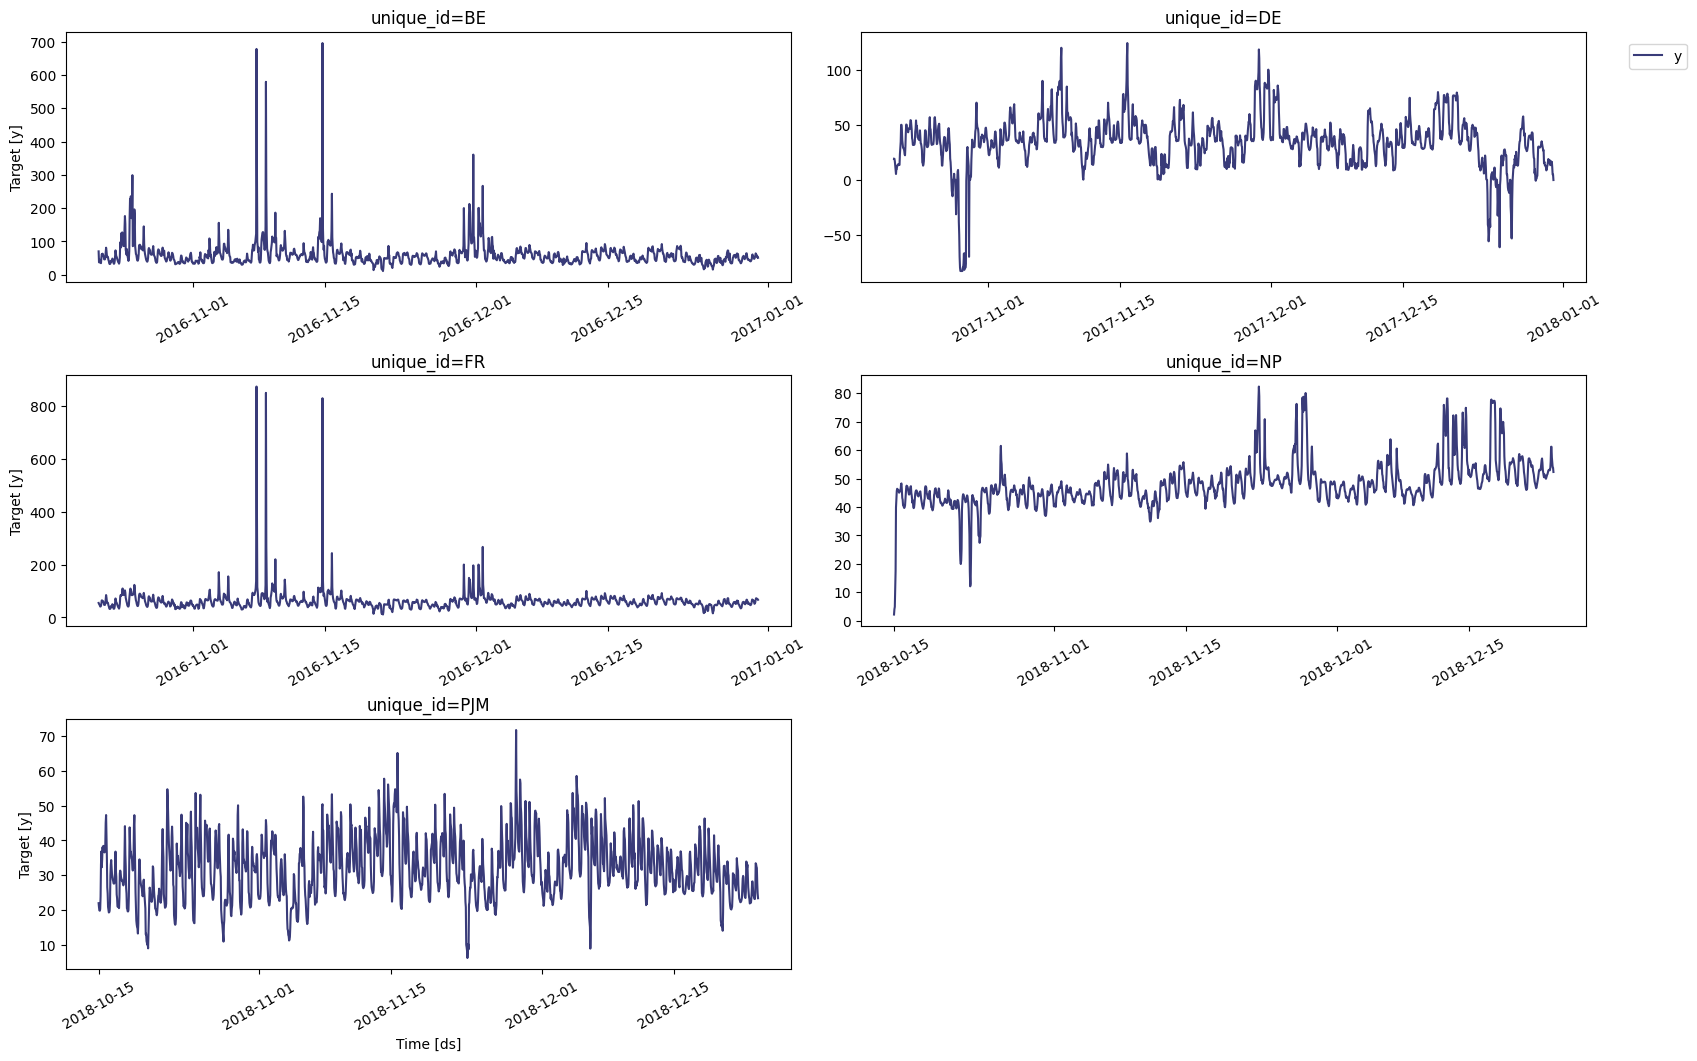

In [ ]:
nixtla_client.plot(df)

## 3. Forecasting Multiple Series

To forecast all series at once, we simply pass the dataframe to the `df` argument. TimeGPt will automatically forecast all series.

In [ ]:
timegpt_fcst_multiseries_df = nixtla_client.forecast(df=df, h=24, level=[80, 90])
timegpt_fcst_multiseries_df.head()

,unique_id,ds,TimeGPT,TimeGPT-hi-80,TimeGPT-hi-90,TimeGPT-lo-80,TimeGPT-lo-90
0,BE,2016-12-31 00:00:00,45.190674,54.872640,57.369972,35.508710,33.011375
1,BE,2016-12-31 01:00:00,43.244910,51.113556,56.101364,35.376266,30.388454
2,BE,2016-12-31 02:00:00,41.958893,48.577103,54.632137,35.340683,29.285650
3,BE,2016-12-31 03:00:00,39.796677,47.265984,49.683872,32.327370,29.909481
4,BE,2016-12-31 04:00:00,39.204560,47.410786,47.677520,30.998333,30.731598


> 📘 Available models in Azure AI
>
> If you are using an Azure AI endpoint, please be sure to set `model="azureai"`:
>
> `nixtla_client.forecast(..., model="azureai")`
>
> For the public API, we support two models: `timegpt-1` and `timegpt-1-long-horizon`.
>
> By default, `timegpt-1` is used. Please see [this tutorial](https://docs.nixtla.io/docs/tutorials-long_horizon_forecasting) on how and when to use `timegpt-1-long-horizon`.

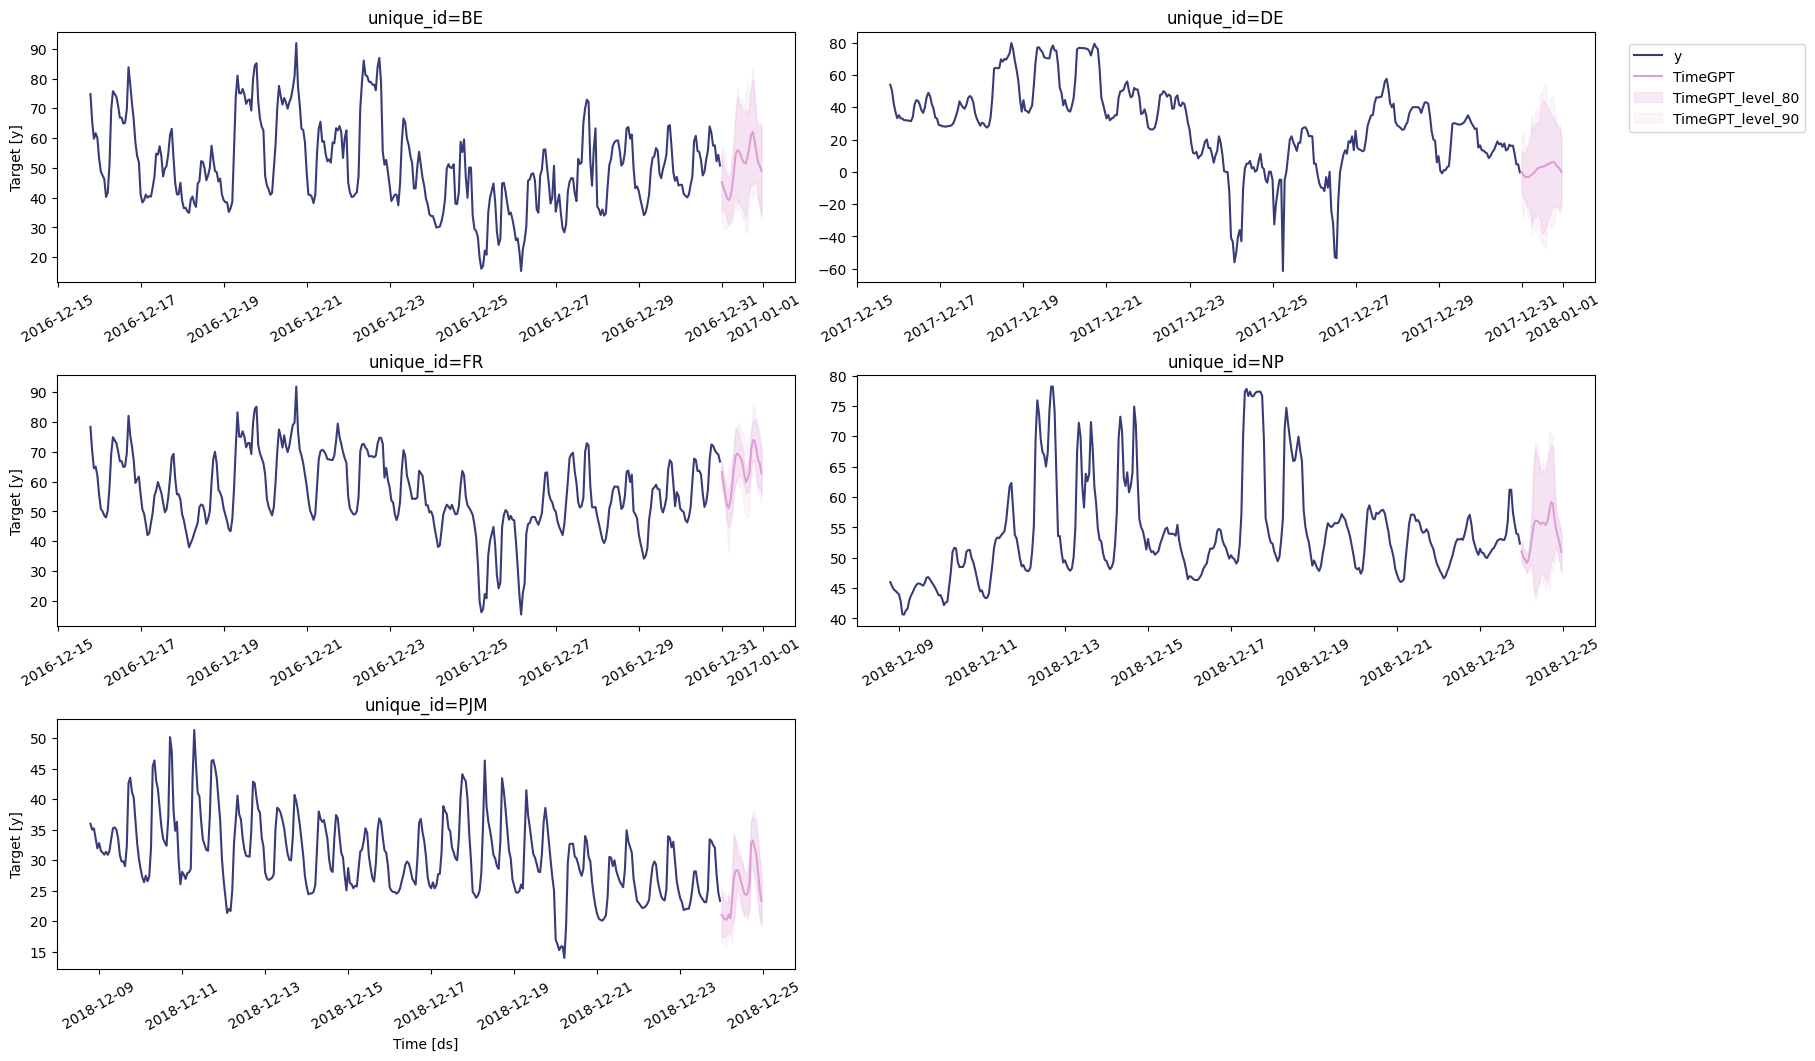

In [ ]:
nixtla_client.plot(df, timegpt_fcst_multiseries_df, max_insample_length=365, level=[80, 90])

From the figure above, we can see that the model effectively generated predictions for each unique series in the dataset.

## Historical forecast

You can also compute prediction intervals for historical forecasts adding the `add_history=True`.

To specify the confidence interval, we use the `level` argument. Here, we pass the list `[80, 90]`. This will compute a 80% and 90% confidence interval.

In [ ]:
timegpt_fcst_multiseries_with_history_df = nixtla_client.forecast(df=df, h=24, level=[80, 90], add_history=True)
timegpt_fcst_multiseries_with_history_df.head()

,unique_id,ds,TimeGPT,TimeGPT-hi-80,TimeGPT-hi-90,TimeGPT-lo-80,TimeGPT-lo-90
0,BE,2016-10-27 00:00:00,56.072800,98.194145,110.13496,13.951457,2.010642
1,BE,2016-10-27 01:00:00,52.414932,94.536280,106.47709,10.293590,-1.647226
2,BE,2016-10-27 02:00:00,52.807762,94.929110,106.86992,10.686419,-1.254396
3,BE,2016-10-27 03:00:00,52.583054,94.704400,106.64521,10.461711,-1.479105
4,BE,2016-10-27 04:00:00,52.671455,94.792800,106.73361,10.550113,-1.390703


> 📘 Available models in Azure AI
>
> If you are using an Azure AI endpoint, please be sure to set `model="azureai"`:
>
> `nixtla_client.forecast(..., model="azureai")`
>
> For the public API, we support two models: `timegpt-1` and `timegpt-1-long-horizon`.
>
> By default, `timegpt-1` is used. Please see [this tutorial](https://docs.nixtla.io/docs/tutorials-long_horizon_forecasting) on how and when to use `timegpt-1-long-horizon`.

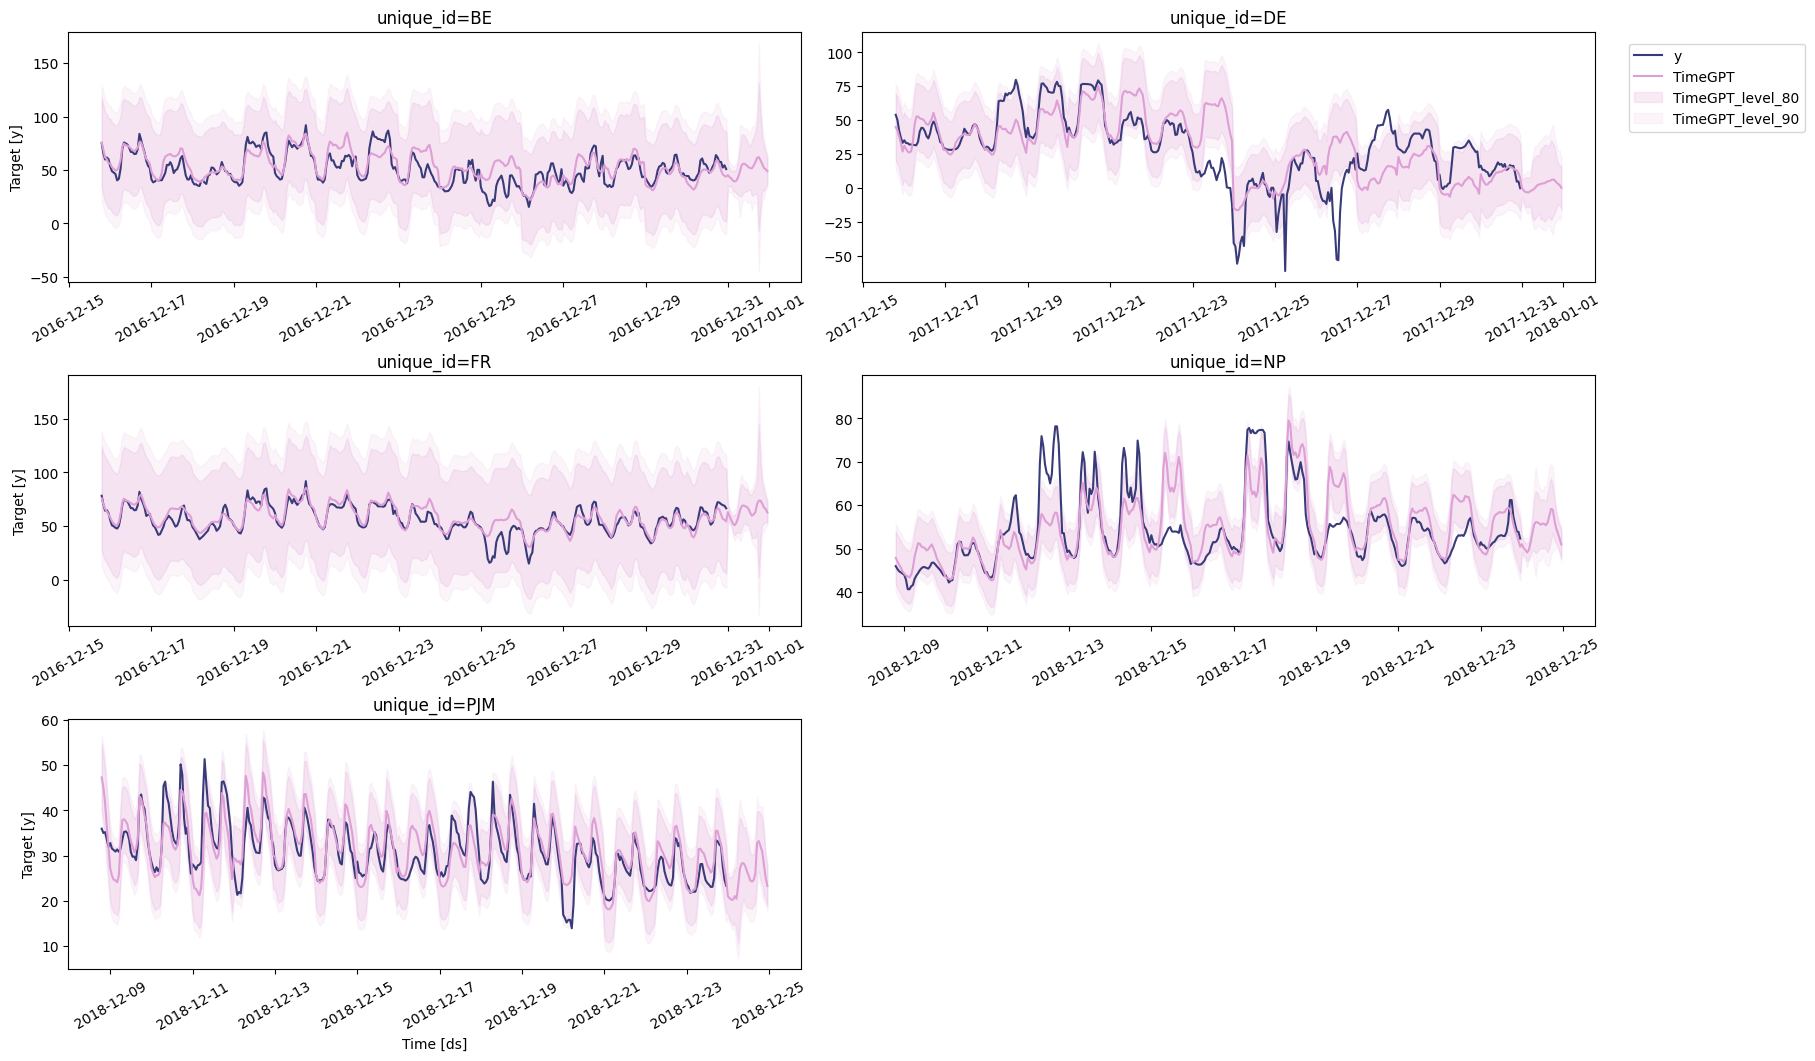

In [ ]:
nixtla_client.plot(
    df,
    timegpt_fcst_multiseries_with_history_df.groupby('unique_id').tail(365 + 24),
    max_insample_length=365,
    level=[80, 90],
)

In the figure above, we now see the historical predictions made by TimeGPT for each series, along with the 80% and 90% confidence intervals.